# Predictions & Overlays (NumPy features)

This notebook:
- loads **pre-extracted features** from your `P5_prp_feat/` folder,
- loads **saved models** (e.g., `rms_matrix`, `all_channels`, the **best** `iterative_add`),
- makes predictions (Fx, Fy, and Angle if available),
- plots **Fx**, **Fy**, and **Angle** overlays,
- prints per-output **MAE** for quick comparison.

> Update the paths in the **Config** cell to match your machine.


In [6]:
# =====================
# Config
# =====================
from pathlib import Path

# Folder with your saved feature .npy files
FEATURE_DIR = Path("/Users/juliahagen/IntMS_EEG/data/preprocessing/P1_prp_feat")

# Folder where training saved models & metrics (by bin_size subfolder)
RESULTS_DIR = Path("./results_feat/P1_angle")

# Which bin_size to evaluate (must match a subfolder in RESULTS_DIR like bin_1000/)
BIN_SIZE = 1000

# How many samples to show in plots (None = all)
PLOT_N_SAMPLES = None  # e.g., 5000

# =====================
# End config
# =====================
print("Using:\n  FEATURE_DIR=", FEATURE_DIR,
      "\n  RESULTS_DIR=", RESULTS_DIR,
      "\n  BIN_SIZE=", BIN_SIZE)

Using:
  FEATURE_DIR= /Users/juliahagen/IntMS_EEG/data/preprocessing/P1_prp_feat 
  RESULTS_DIR= results_feat/P1_angle 
  BIN_SIZE= 1000


In [7]:
import os, glob, math, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
import joblib

def angle_from_fname(fname: str) -> float:
    """Parse the angle as the number before the first '_' in the filename.
    Fallback: '<num>deg' anywhere in the name.
    """
    base = Path(fname).stem
    first_token = base.split('_', 1)[0]
    m = re.match(r'^\s*([+-]?\d+(?:\.\d+)?)', first_token)
    if m: 
        return float(m.group(1))
    m = re.search(r'([+-]?\d+(?:\.\d+)?)\s*deg', base, flags=re.IGNORECASE)
    if m:
        return float(m.group(1))
    raise ValueError(f"Cannot parse angle from filename: {fname}")

def load_feature_file(path):
    obj = np.load(path, allow_pickle=True)
    d = {k: obj[k] for k in obj.files} if isinstance(obj, np.lib.npyio.NpzFile) else (obj.item() if hasattr(obj, "item") else obj)
    for k in ("emg_rms_matrix_binned", "ref_binned", "bin_size"):
        if k not in d:
            raise KeyError(f"{Path(path).name} missing key '{k}'")
    R  = np.asarray(d["emg_rms_matrix_binned"], dtype=float)  # (B,C)
    mag= np.asarray(d["ref_binned"], dtype=float).reshape(-1) # (B,)
    B  = min(R.shape[0], mag.shape[0])
    R, mag = R[:B,:], mag[:B]
    ang= angle_from_fname(path)
    return R, mag, int(np.asarray(d["bin_size"]).squeeze()), ang

def collect_dataset(feature_dir: Path, include_angle=True):
    files = sorted(glob.glob(str(feature_dir / "*.npy"))) + sorted(glob.glob(str(feature_dir / "*.npz")))
    if not files:
        raise FileNotFoundError(f"No feature files found in {feature_dir}")
    Xs, ys, used_files, bins_found = [], [], [], set()
    for p in files:
        try:
            R, mag, bs, ang = load_feature_file(p)
        except Exception as e:
            print("[SKIP]", Path(p).name, "->", e); 
            continue
        bins_found.add(bs)
        theta = math.radians(ang)
        fx, fy = mag * math.cos(theta), mag * math.sin(theta)
        y = np.column_stack([fx, fy, np.full_like(fx, ang, dtype=float)]) if include_angle else np.column_stack([fx, fy])
        Xs.append(R); ys.append(y); used_files.append(p)
    X = np.vstack(Xs); y = np.vstack(ys)
    return X, y, sorted(bins_found), used_files

def build_X(R, mode, channels=None):
    if mode == "rms_matrix":         return R
    if mode == "all_channels":       return np.sqrt(np.mean(R**2, axis=1, keepdims=True))
    if mode == "average_channels":   return R.mean(axis=1, keepdims=True)
    if mode == "single_ch_0":        return R[:, [0]]
    if mode.startswith("iterative_add_k"):
        k = int(mode.split("_k")[-1])
        return R[:, :k]
    raise ValueError(f"Unknown mode {mode}")

def load_model_bundle(results_dir: Path, bin_size: int):
    bin_dir = results_dir / f"bin_{bin_size}"
    metrics_csv = bin_dir / "metrics.csv"
    if not metrics_csv.exists():
        raise FileNotFoundError(f"Missing metrics.csv in {bin_dir}")
    df = pd.read_csv(metrics_csv)

    # Pick best iterative_add (lowest MAE)
    best_iter = df[df["mode"]=="iterative_add"].sort_values("mae").head(1)
    best_k = int(best_iter["k_channels"].iloc[0]) if not best_iter.empty else None

    model_files = {
        "rms_matrix": bin_dir / "ridge_rms_matrix.joblib",
        "all_channels": bin_dir / "ridge_all_channels.joblib",
        "average_channels": bin_dir / "ridge_average_channels.joblib",
        # Uncomment if you trained it:
        # "single_ch_0": bin_dir / "ridge_single_ch_0.joblib",
    }
    if best_k:
        model_files[f"iterative_add_k{best_k}"] = bin_dir / f"ridge_iterative_add_k{best_k}.joblib"

    y_scaler_path = bin_dir / "y_scaler.joblib"
    y_scaler = joblib.load(y_scaler_path) if y_scaler_path.exists() else None

    models = {}
    for name, p in model_files.items():
        if p.exists():
            models[name] = (joblib.load(p), y_scaler)
        else:
            print(f"[WARN] Missing model: {p}")
    return models, df, bin_dir, best_k

def per_output_mae(y_true, y_pred):
    names = ["Fx","Fy","Angle"] if y_true.shape[1]==3 else ["Fx","Fy"]
    maes = {}
    for i,n in enumerate(names):
        maes[n] = float(np.mean(np.abs(y_true[:,i] - y_pred[:,i])))
    return maes

print("Helpers loaded.")

Helpers loaded.


In [8]:
# Load data and models
X, y, bins_avail, files_used = collect_dataset(FEATURE_DIR, include_angle=True)
print("Available bin sizes in data:", bins_avail)
if BIN_SIZE not in bins_avail:
    print(f"[WARN] BIN_SIZE {BIN_SIZE} not in data; you may want one of {bins_avail}")

models, metrics_df, bin_dir, best_k = load_model_bundle(RESULTS_DIR, BIN_SIZE)
print("Using models from:", bin_dir)
if best_k:
    print("Best iterative_add k =", best_k)

# (Optional) inspect metrics
metrics_df

Available bin sizes in data: [1000]
Using models from: results_feat/P1_angle/bin_1000
Best iterative_add k = 12


,mode,k_channels,mse,mae
0,rms_matrix,NaN,0.086547,0.241449
1,all_channels,NaN,0.207532,0.397885
2,average_channels,NaN,0.204731,0.392977
3,single_ch_0,NaN,0.140579,0.311239
4,iterative_add,1.0,0.140579,0.311239
5,iterative_add,2.0,0.128194,0.298856
6,iterative_add,3.0,0.094596,0.254732
7,iterative_add,4.0,0.100355,0.261279
8,iterative_add,5.0,0.100288,0.259765
9,iterative_add,6.0,0.091458,0.245782


In [9]:
# Run predictions and compute MAEs
results = {}
for name, (model, y_scaler) in models.items():
    Xd = build_X(X, name)
    y_hat = model.predict(Xd)
    if y_scaler is not None:
        y_hat = y_scaler.inverse_transform(y_hat)

    # If model didn't output angle explicitly, derive from Fx/Fy for plotting/angle MAE
    if y_hat.shape[1] == 2 and y.shape[1] == 3:
        ang_pred = np.degrees(np.arctan2(y_hat[:,1], y_hat[:,0]))
        y_hat = np.column_stack([y_hat, ang_pred])

    # Compute per-output MAE (Fx, Fy, Angle if present)
    maes = per_output_mae(y, y_hat)
    results[name] = {"y_hat": y_hat, "mae": maes}

# Show MAEs table
rows = []
for name, d in results.items():
    entry = {"model": name, **d["mae"]}
    rows.append(entry)
mae_df = pd.DataFrame(rows).set_index("model").sort_values(by=list(rows[0].keys())[1:])
mae_df

,Fx,Fy,Angle
model,,,
rms_matrix,0.870087,0.746710,15.859422
iterative_add_k12,0.938952,0.766230,16.814105
average_channels,1.938902,1.205066,32.682429
all_channels,2.015979,1.198980,33.180573


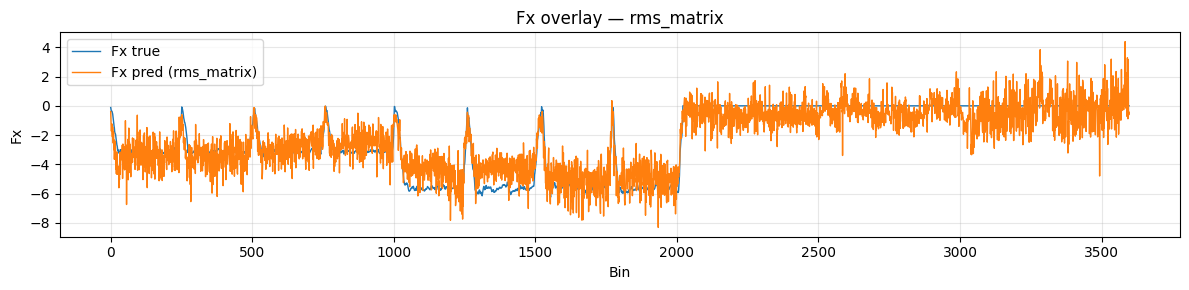

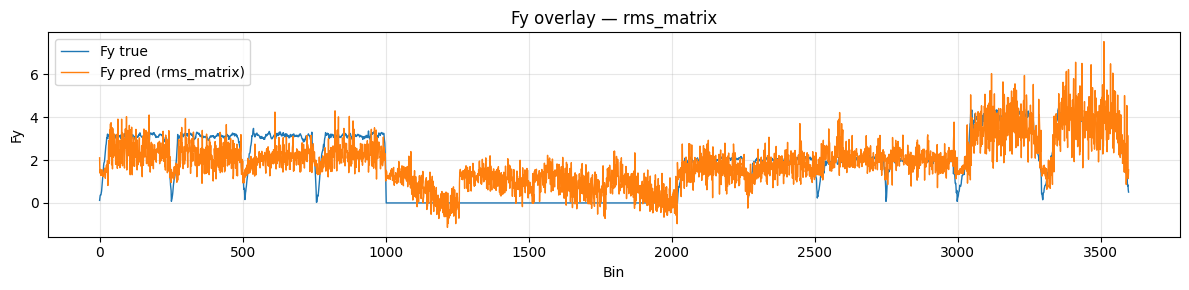

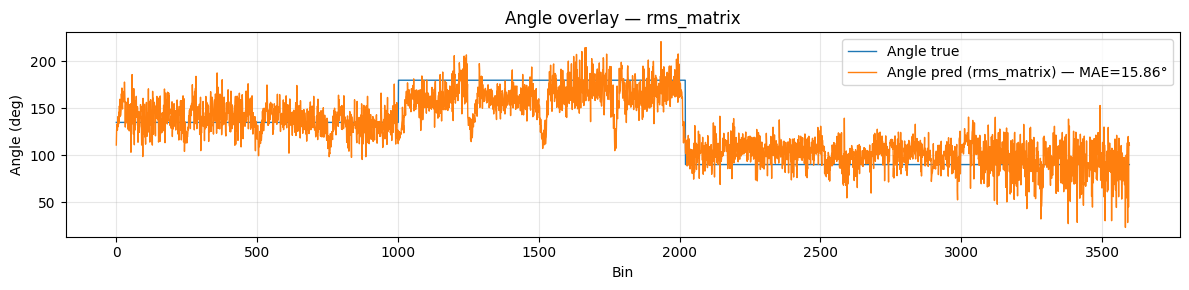

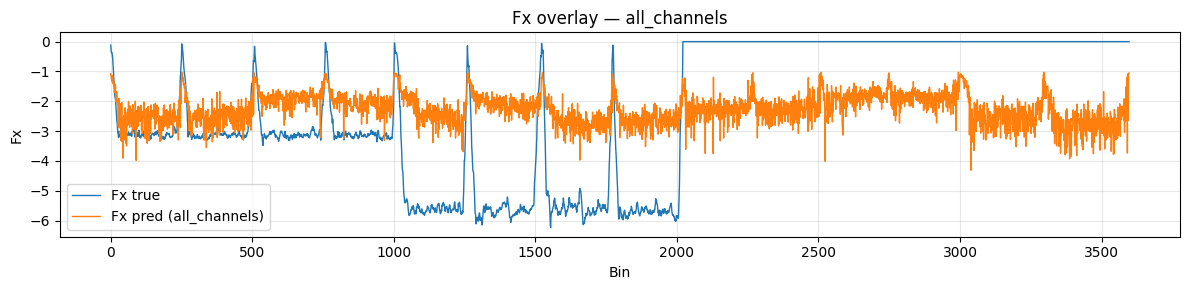

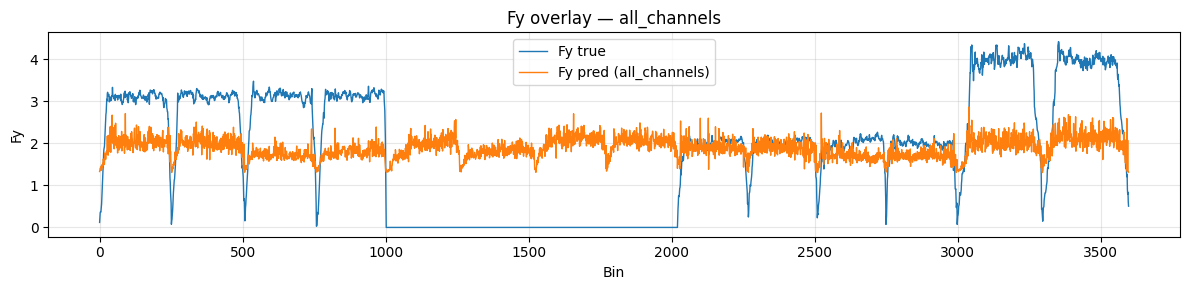

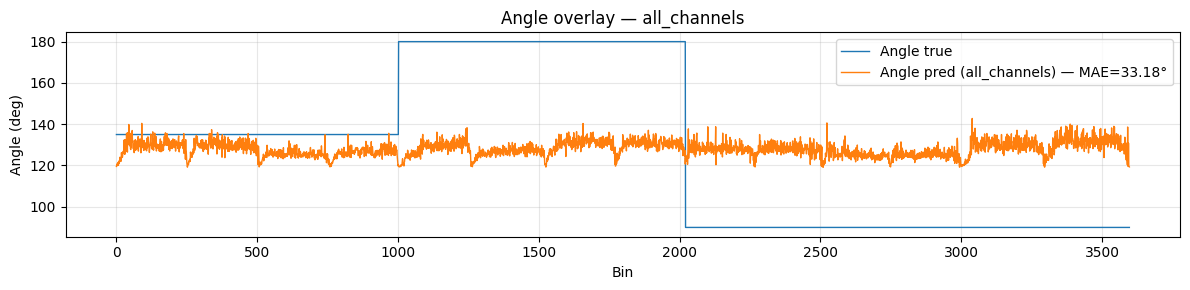

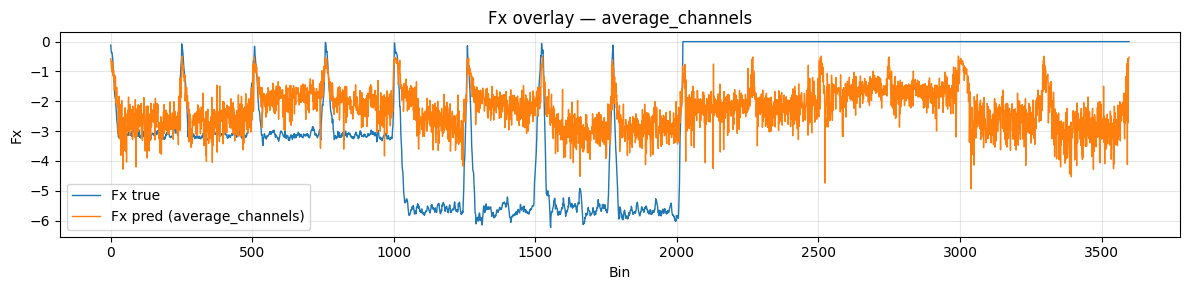

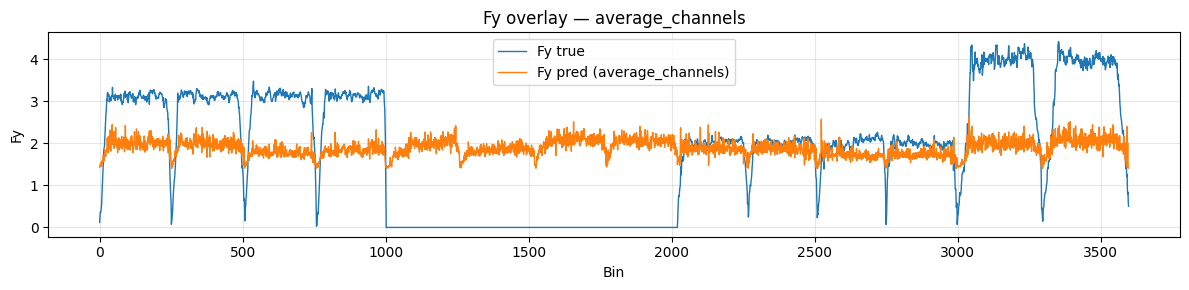

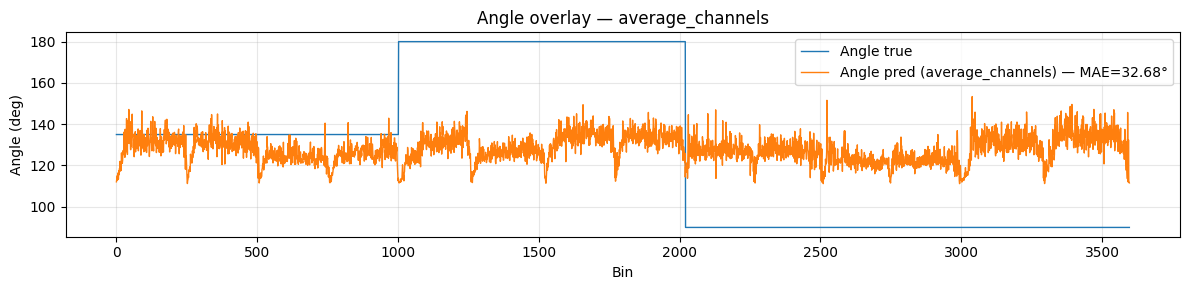

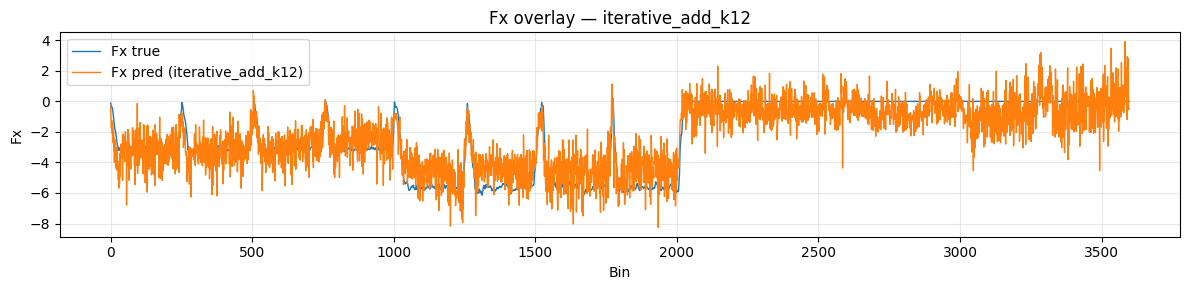

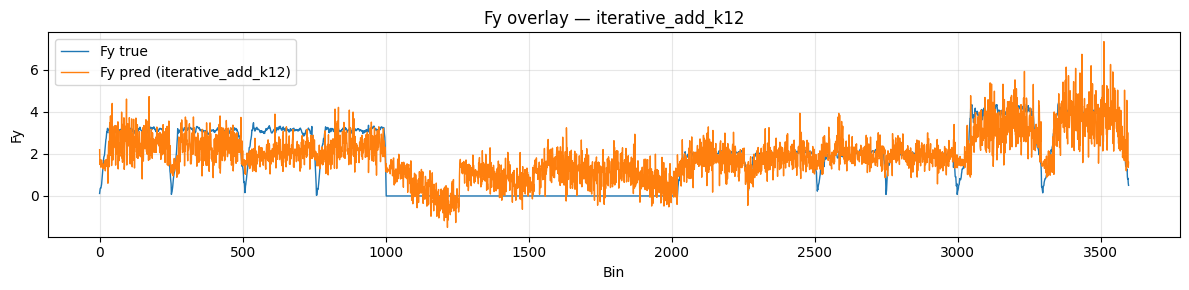

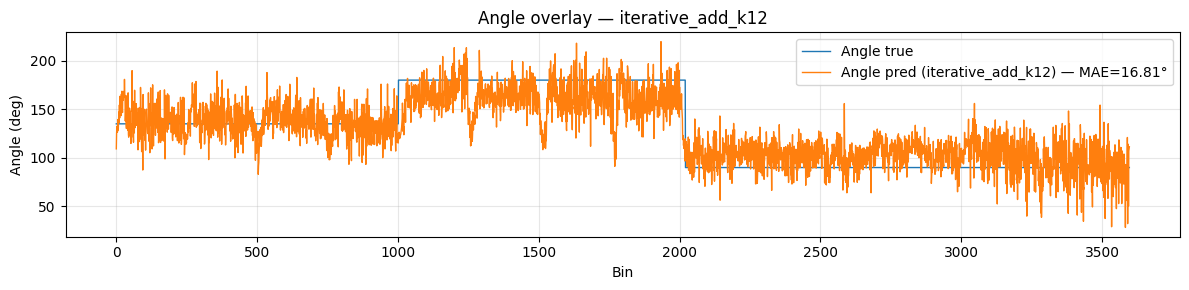

Saved PNGs to: results_feat/P1_angle/bin_1000/predictions_plots


In [10]:
# Plot overlays for each model
def _maybe_slice(t, arr):
    if PLOT_N_SAMPLES is None:
        return t, arr
    n = min(len(t), PLOT_N_SAMPLES)
    return t[:n], arr[:n]

os.makedirs(bin_dir / "predictions_plots", exist_ok=True)

for name, d in results.items():
    y_hat = d["y_hat"]
    t = np.arange(len(y))

    # Limit to N samples if requested
    t_fx, fx_true = _maybe_slice(t, y[:,0])
    _, fx_pred = _maybe_slice(t, y_hat[:,0])
    t_fy, fy_true = _maybe_slice(t, y[:,1])
    _, fy_pred = _maybe_slice(t, y_hat[:,1])

    # Fx
    plt.figure(figsize=(12,3))
    plt.plot(t_fx, fx_true, lw=1.0, label="Fx true")
    plt.plot(t_fx, fx_pred, lw=1.0, label=f"Fx pred ({name})")
    plt.xlabel("Bin"); plt.ylabel("Fx"); plt.grid(True, alpha=0.3); plt.legend()
    plt.title(f"Fx overlay — {name}")
    plt.tight_layout(); 
    out_fx = bin_dir / "predictions_plots" / f"Fx_overlay_{name}.png"
    plt.savefig(out_fx, dpi=150); plt.show()

    # Fy
    plt.figure(figsize=(12,3))
    plt.plot(t_fy, fy_true, lw=1.0, label="Fy true")
    plt.plot(t_fy, fy_pred, lw=1.0, label=f"Fy pred ({name})")
    plt.xlabel("Bin"); plt.ylabel("Fy"); plt.grid(True, alpha=0.3); plt.legend()
    plt.title(f"Fy overlay — {name}")
    plt.tight_layout();
    out_fy = bin_dir / "predictions_plots" / f"Fy_overlay_{name}.png"
    plt.savefig(out_fy, dpi=150); plt.show()

    # Angle
    if y.shape[1] >= 3:
        ang_true = y[:,2]
    else:
        ang_true = np.degrees(np.arctan2(y[:,1], y[:,0]))

    if y_hat.shape[1] >= 3:
        ang_pred = y_hat[:,2]
    else:
        ang_pred = np.degrees(np.arctan2(y_hat[:,1], y_hat[:,0]))

    t_ang, a_true = _maybe_slice(t, ang_true)
    _, a_pred = _maybe_slice(t, ang_pred)

    # wrap error to [-180,180] to compute MAE
    diff = (a_pred - a_true + 180) % 360 - 180
    ang_mae = np.mean(np.abs(diff))

    plt.figure(figsize=(12,3))
    plt.plot(t_ang, a_true, lw=1.0, label="Angle true")
    plt.plot(t_ang, a_pred, lw=1.0, label=f"Angle pred ({name}) — MAE={ang_mae:.2f}°")
    plt.xlabel("Bin"); plt.ylabel("Angle (deg)"); plt.grid(True, alpha=0.3); plt.legend()
    plt.title(f"Angle overlay — {name}")
    plt.tight_layout();
    out_ang = bin_dir / "predictions_plots" / f"Angle_overlay_{name}.png"
    plt.savefig(out_ang, dpi=150); plt.show()

print("Saved PNGs to:", bin_dir / "predictions_plots")

In [11]:
# Build an index to slice the aggregated y / predictions back to each file

import glob, re, math
from pathlib import Path
import numpy as np

def _angle_from_fname(fname):
    base = Path(fname).stem
    tok  = base.split('_', 1)[0]
    m = re.match(r'^\s*([+-]?\d+(?:\.\d+)?)', tok)
    if m: return float(m.group(1))
    m = re.search(r'([+-]?\d+(?:\.\d+)?)\s*deg', base, flags=re.IGNORECASE)
    if m: return float(m.group(1))
    raise ValueError(f"Cannot parse angle from filename: {fname}")

def _bins_in_file(path):
    obj = np.load(path, allow_pickle=True)
    d = obj.item() if hasattr(obj, "item") else obj
    R  = np.asarray(d["emg_rms_matrix_binned"])
    ref= np.asarray(d["ref_binned"]).reshape(-1)
    B  = min(R.shape[0], ref.shape[0])
    return B, _angle_from_fname(path)

# Make file index (must be the SAME order used when you built X,y earlier → sorted glob)
files_sorted = sorted(glob.glob(str(FEATURE_DIR / "*.npy")) + glob.glob(str(FEATURE_DIR / "*.npz")))
file_index = []
cursor = 0
for p in files_sorted:
    B, ang = _bins_in_file(p)
    file_index.append({"file": p, "start": cursor, "end": cursor+B, "bins": B, "angle_deg": ang})
    cursor += B

assert cursor == len(y), f"Index length {cursor} != y length {len(y)} (ordering mismatch?)"
print(f"Indexed {len(file_index)} files • total bins={cursor}")
print("Example:", Path(file_index[0]['file']).name, "→ slice", file_index[0]['start'], file_index[0]['end'])


Indexed 14 files • total bins=3598
Example: 135_F1_1_1.npy → slice 0 251


File[0]: 135_F1_1_1.npy | bins: 251 | label angle: 135.0


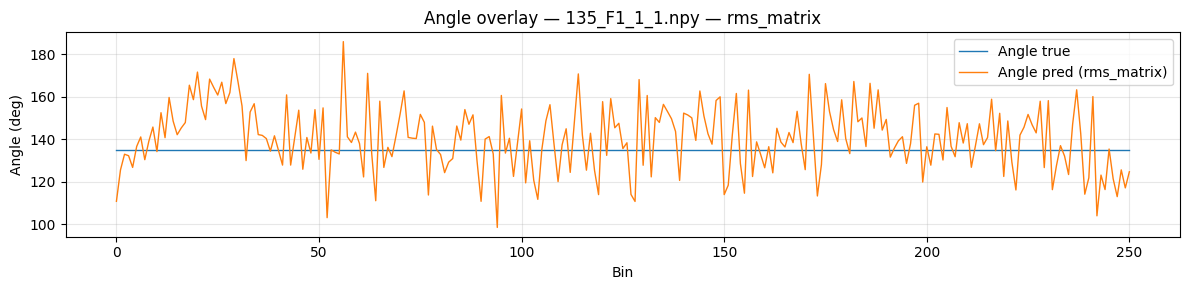

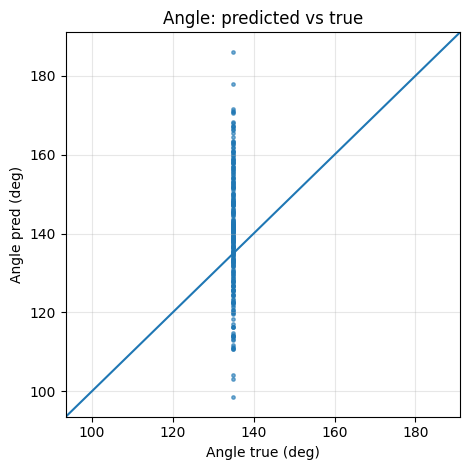

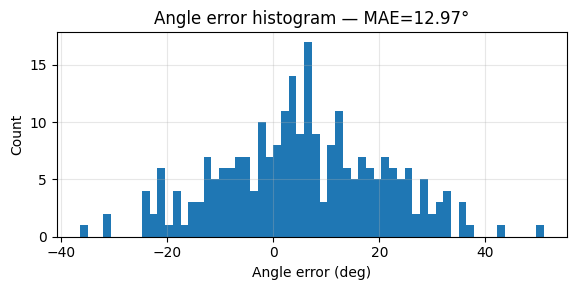

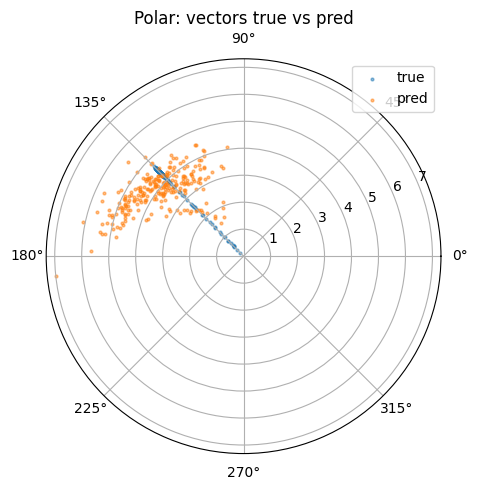

Per-file MAE  |  Fx: 0.809   Fy: 0.777   Angle(deg): 12.97


In [13]:
# Select a file + model to inspect (isolated sample)
FILE_IDX   = 0                         # 0 .. len(file_index)-1
MODEL_NAME = "rms_matrix"             # e.g. "rms_matrix", "all_channels", "iterative_add_k<best>"

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

rec = file_index[FILE_IDX]
s, e = rec["start"], rec["end"]
print(f"File[{FILE_IDX}]:", Path(rec["file"]).name, "| bins:", rec["bins"], "| label angle:", rec["angle_deg"])

# Slice true targets for this file from the aggregated y
y_file = y[s:e]

# Grab this model's full-dataset predictions you already computed in `results`
assert MODEL_NAME in results, f"MODEL_NAME '{MODEL_NAME}' not in {list(results.keys())}"
y_hat_full = results[MODEL_NAME]["y_hat"]
y_hat_file = y_hat_full[s:e]

# If angle column not present, derive from Fx/Fy
def _ensure_angle(col):
    if col.shape[1] >= 3:
        return col
    ang = np.degrees(np.arctan2(col[:,1], col[:,0]))
    return np.column_stack([col, ang])

y_file = _ensure_angle(y_file)
y_hat_file = _ensure_angle(y_hat_file)

# Optional limit for plotting
def _trim(a):
    if PLOT_N_SAMPLES is None: return a
    n = min(len(a), PLOT_N_SAMPLES); return a[:n]

t = np.arange(len(y_file)); t = _trim(t)
Fx_t, Fy_t, Ang_t = _trim(y_file[:,0]), _trim(y_file[:,1]), _trim(y_file[:,2])
Fx_p, Fy_p, Ang_p = _trim(y_hat_file[:,0]), _trim(y_hat_file[:,1]), _trim(y_hat_file[:,2])

# ---- Angle overlay
plt.figure(figsize=(12,3))
plt.plot(t, Ang_t, lw=1.0, label="Angle true")
plt.plot(t, Ang_p, lw=1.0, label=f"Angle pred ({MODEL_NAME})")
plt.xlabel("Bin"); plt.ylabel("Angle (deg)"); plt.grid(True, alpha=0.3); plt.legend()
plt.title(f"Angle overlay — {Path(rec['file']).name} — {MODEL_NAME}")
plt.tight_layout(); plt.show()

# ---- Scatter: pred vs true angle
plt.figure(figsize=(4.8,4.8))
plt.scatter(Ang_t, Ang_p, s=6, alpha=0.6)
lims = [min(Ang_t.min(), Ang_p.min())-5, max(Ang_t.max(), Ang_p.max())+5]
plt.plot(lims, lims); plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Angle true (deg)"); plt.ylabel("Angle pred (deg)"); plt.grid(True, alpha=0.3)
plt.title("Angle: predicted vs true")
plt.tight_layout(); plt.show()

# ---- Histogram of angle error (wrapped to [-180,180])
ang_err = (Ang_p - Ang_t + 180) % 360 - 180
ang_mae = float(np.mean(np.abs(ang_err)))
plt.figure(figsize=(6,3))
plt.hist(ang_err, bins=60)
plt.xlabel("Angle error (deg)"); plt.ylabel("Count"); plt.grid(True, alpha=0.3)
plt.title(f"Angle error histogram — MAE={ang_mae:.2f}°")
plt.tight_layout(); plt.show()

# ---- Polar plot of vectors (Fx,Fy): true vs pred
plt.figure(figsize=(5,5))
ax = plt.subplot(111, polar=True)
theta_t = np.radians(Ang_t); rho_t = np.sqrt(Fx_t**2 + Fy_t**2)
theta_p = np.radians(Ang_p); rho_p = np.sqrt(Fx_p**2 + Fy_p**2)
ax.scatter(theta_t, rho_t, s=4, alpha=0.5, label="true")
ax.scatter(theta_p, rho_p, s=4, alpha=0.5, label="pred")
ax.set_title("Polar: vectors true vs pred")
ax.legend(loc="upper right")
plt.tight_layout(); plt.show()

# ---- Per-file MAE printout
mae_fx = float(np.mean(np.abs(Fx_t - Fx_p)))
mae_fy = float(np.mean(np.abs(Fy_t - Fy_p)))
print(f"Per-file MAE  |  Fx: {mae_fx:.3f}   Fy: {mae_fy:.3f}   Angle(deg): {ang_mae:.2f}")


In [15]:
# === Per-angle evaluation over the whole dataset ===
# Uses your aggregated y and the predictions already in `results`.

import glob, re, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MODEL_NAME_CMP = "rms_matrix"   # change to compare another model (must exist in `results`)

def _angle_from_fname(fname):
    base = Path(fname).stem
    tok  = base.split('_', 1)[0]
    m = re.match(r'^\s*([+-]?\d+(?:\.\d+)?)', tok)
    if m: return float(m.group(1))
    m = re.search(r'([+-]?\d+(?:\.\d+)?)\\s*deg', base, flags=re.IGNORECASE)
    if m: return float(m.group(1))
    raise ValueError(f"Cannot parse angle: {fname}")

def _bins_in_file(path):
    obj = np.load(path, allow_pickle=True)
    d = obj.item() if hasattr(obj, "item") else obj
    R  = np.asarray(d["emg_rms_matrix_binned"])
    ref= np.asarray(d["ref_binned"]).reshape(-1)
    B  = min(R.shape[0], ref.shape[0])
    return B, _angle_from_fname(path)

# Build file_index if not present (must match order used to build X,y)
if "file_index" not in globals():
    files_sorted = sorted(glob.glob(str(FEATURE_DIR / "*.npy")) + glob.glob(str(FEATURE_DIR / "*.npz")))
    file_index = []
    cursor = 0
    for p in files_sorted:
        B, ang = _bins_in_file(p)
        file_index.append({"file": p, "start": cursor, "end": cursor+B, "bins": B, "angle_deg": ang})
        cursor += B
    assert cursor == len(y), f"Index length {cursor} != y length {len(y)}"

# Pull true angles from y (or derive if only Fx,Fy present)
if y.shape[1] >= 3:
    ang_true_all = y[:,2]
else:
    ang_true_all = np.degrees(np.arctan2(y[:,1], y[:,0]))

# Pick model predictions already computed in `results`
assert MODEL_NAME_CMP in results, f"{MODEL_NAME_CMP} not in results: {list(results.keys())}"
yhat_all = results[MODEL_NAME_CMP]["y_hat"]
ang_pred_all = (yhat_all[:,2] if yhat_all.shape[1] >= 3 
                else np.degrees(np.arctan2(yhat_all[:,1], yhat_all[:,0])))

# Wrap error to [-180, 180]
ang_err_all = (ang_pred_all - ang_true_all + 180) % 360 - 180
abs_err_all = np.abs(ang_err_all)

# Aggregate per-file, then per-angle label
rows = []
for rec in file_index:
    s, e = rec["start"], rec["end"]
    a = rec["angle_deg"]
    ae = abs_err_all[s:e]
    rows.append({
        "file": Path(rec["file"]).name,
        "angle_deg": a,
        "n_bins": len(ae),
        "mae": float(ae.mean()),
        "median_ae": float(np.median(ae)),
        "p90_ae": float(np.percentile(ae, 90)),
        "bias": float(((ang_pred_all[s:e] - ang_true_all[s:e] + 180) % 360 - 180).mean()),
        "std_err": float(ang_err_all[s:e].std())
    })

df_files = pd.DataFrame(rows)

# Collapse to per-angle summary
df_angle = (df_files
            .groupby("angle_deg")
            .agg(n_files=("file","count"),
                 n_bins=("n_bins","sum"),
                 mae=("mae","mean"),
                 median_ae=("median_ae","mean"),
                 p90_ae=("p90_ae","mean"),
                 bias=("bias","mean"),
                 std_err=("std_err","mean"))
            .reset_index()
            .sort_values("angle_deg"))
df_angle


,angle_deg,n_files,n_bins,mae,median_ae,p90_ae,bias,std_err
0,90.0,6,1577,15.367924,14.286007,28.636117,9.519046,14.803518
1,135.0,4,1002,11.649294,9.624287,23.924997,3.306474,14.031654
2,180.0,4,1019,20.506034,18.023220,38.670226,-17.385581,17.323181


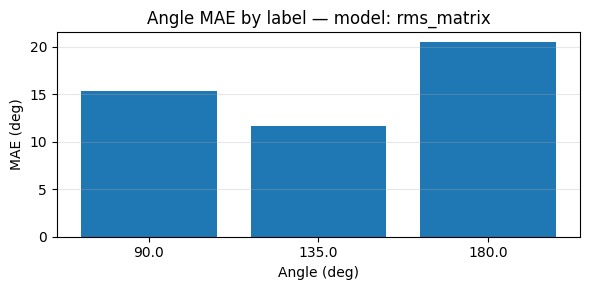

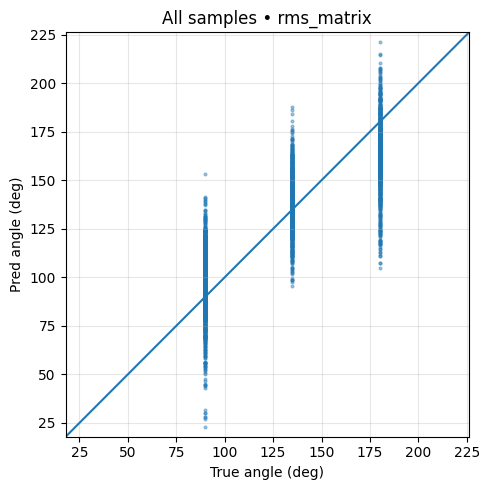

In [16]:
# --- Bar chart: MAE by angle for the chosen model ---
plt.figure(figsize=(6,3))
plt.bar(df_angle["angle_deg"].astype(str), df_angle["mae"])
plt.xlabel("Angle (deg)")
plt.ylabel("MAE (deg)")
plt.title(f"Angle MAE by label — model: {MODEL_NAME_CMP}")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout(); plt.show()

# --- (Optional) scatter: predicted vs true angle for ALL samples (all files) ---
t_true = ang_true_all
t_pred = ang_pred_all
plt.figure(figsize=(5,5))
plt.scatter(t_true, t_pred, s=4, alpha=0.4)
lims = [min(t_true.min(), t_pred.min())-5, max(t_true.max(), t_pred.max())+5]
plt.plot(lims, lims)
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("True angle (deg)")
plt.ylabel("Pred angle (deg)")
plt.title(f"All samples • {MODEL_NAME_CMP}")
plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


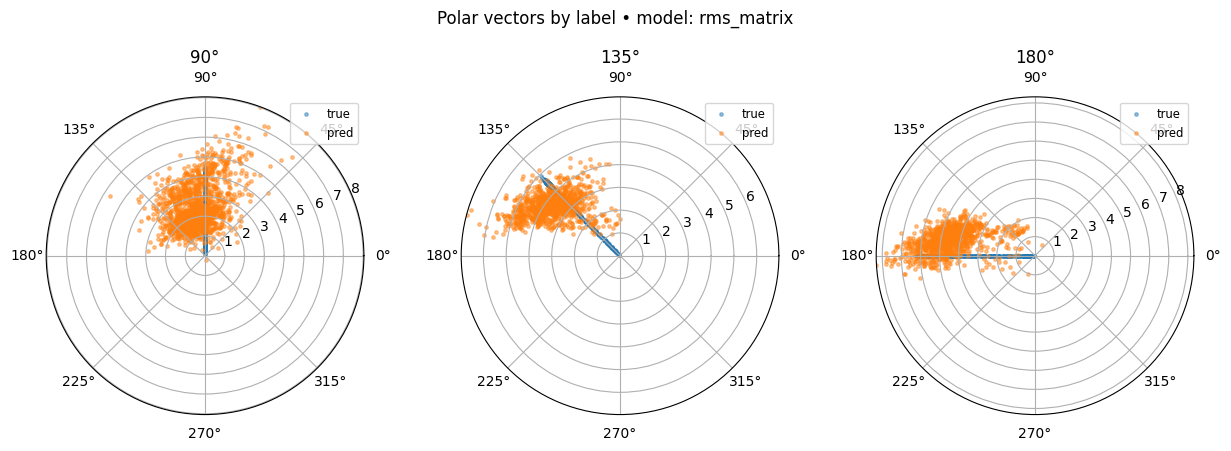

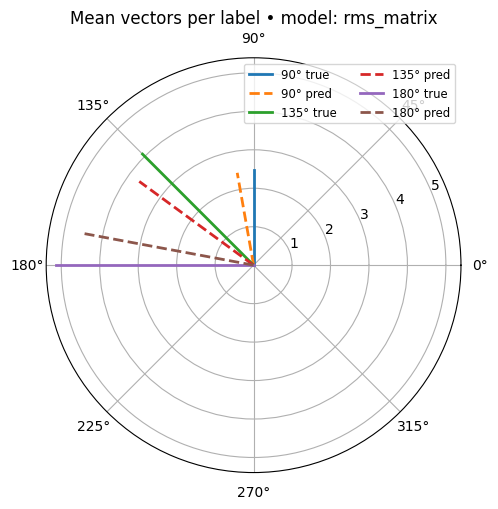

In [18]:
# === Polar plots: true vs predicted vectors, grouped by label angle ===
# Uses: results (dict of models -> {"y_hat": ...}), y (Nx2 or Nx3), FEATURE_DIR
# If file_index isn't built yet, we'll build it to recover per-file angle labels.

import numpy as np, glob, re, math
from pathlib import Path
import matplotlib.pyplot as plt

MODEL_NAME_POLAR = "rms_matrix"   # change to any key in `results`
MAX_POINTS_PER_ANGLE = 4000       # downsample for readability; set None for all

# --- ensure file_index (maps sample ranges to file + its label angle) ---
def _angle_from_fname(fname):
    base = Path(fname).stem
    tok  = base.split('_', 1)[0]
    m = re.match(r'^\s*([+-]?\d+(?:\.\d+)?)', tok)
    if m: return float(m.group(1))
    m = re.search(r'([+-]?\d+(?:\.\d+)?)\s*deg', base, flags=re.IGNORECASE)
    if m: return float(m.group(1))
    raise ValueError(f"Cannot parse angle: {fname}")

def _bins_in_file(path):
    obj = np.load(path, allow_pickle=True)
    d = obj.item() if hasattr(obj, "item") else obj
    R  = np.asarray(d["emg_rms_matrix_binned"])
    ref= np.asarray(d["ref_binned"]).reshape(-1)
    return min(R.shape[0], ref.shape[0]), _angle_from_fname(path)

if "file_index" not in globals():
    files_sorted = sorted(glob.glob(str(FEATURE_DIR / "*.npy")) + glob.glob(str(FEATURE_DIR / "*.npz")))
    file_index = []
    cursor = 0
    for p in files_sorted:
        B, ang = _bins_in_file(p)
        file_index.append({"file": p, "start": cursor, "end": cursor+B, "bins": B, "angle_deg": ang})
        cursor += B
    assert cursor == len(y), f"Index length {cursor} != y length {len(y)}"

# --- build Fx,Fy true and pred arrays for ALL samples ---
Fx_true, Fy_true = y[:,0], y[:,1]
yhat = results[MODEL_NAME_POLAR]["y_hat"]
if yhat.shape[1] >= 2:
    Fx_pred, Fy_pred = yhat[:,0], yhat[:,1]
else:
    raise ValueError(f"`results[{MODEL_NAME_POLAR}]['y_hat']` doesn't have Fx,Fy columns")

# per-sample label angle (from file it came from)
labels = np.empty(len(y), dtype=float)
for rec in file_index:
    labels[rec["start"]:rec["end"]] = rec["angle_deg"]

angles = sorted(np.unique(labels))

# --- helper: take a safe random subset of indices for each label angle ---
def _subset_idx(mask, cap):
    idx = np.flatnonzero(mask)
    if cap is None or len(idx) <= cap: return idx
    rng = np.random.default_rng(0)
    return rng.choice(idx, size=cap, replace=False)

# --- Small multiples: one polar subplot per angle label ---
nA = len(angles)
ncols = min(3, nA)
nrows = (nA + ncols - 1) // ncols
fig = plt.figure(figsize=(4.2*ncols, 4.2*nrows))
for i, a in enumerate(angles, 1):
    mask = labels == a
    sel  = _subset_idx(mask, MAX_POINTS_PER_ANGLE)

    # true
    theta_t = np.arctan2(Fy_true[sel], Fx_true[sel])
    rho_t   = np.sqrt(Fx_true[sel]**2 + Fy_true[sel]**2)
    # pred
    theta_p = np.arctan2(Fy_pred[sel], Fx_pred[sel])
    rho_p   = np.sqrt(Fx_pred[sel]**2 + Fy_pred[sel]**2)

    ax = fig.add_subplot(nrows, ncols, i, projection="polar")
    ax.scatter(theta_t, rho_t, s=6, alpha=0.45, label="true")
    ax.scatter(theta_p, rho_p, s=6, alpha=0.45, label="pred")
    ax.set_title(f"{int(a)}°")
    ax.legend(loc="upper right", fontsize="small")
    # optional: same radial scale across subplots
    rmax = max(rho_t.max() if rho_t.size else 0, rho_p.max() if rho_p.size else 0)
    if np.isfinite(rmax) and rmax > 0:
        ax.set_rlim(0, rmax)

fig.suptitle(f"Polar vectors by label • model: {MODEL_NAME_POLAR}", y=1.02)
plt.tight_layout()
plt.show()

# --- Summary polar: mean vector per angle (true vs pred) ---
def _mean_vec(fx, fy, m):
    # mean of vectors (not magnitudes): average components, then convert to polar
    mx, my = fx[m].mean(), fy[m].mean()
    return np.arctan2(my, mx), np.sqrt(mx**2 + my**2)

plt.figure(figsize=(5.2,5.2))
ax = plt.subplot(111, projection="polar")

for a in angles:
    m = labels == a
    th_t, r_t = _mean_vec(Fx_true, Fy_true, m)
    th_p, r_p = _mean_vec(Fx_pred, Fy_pred, m)

    # plot as short rays from origin (0->mean vector)
    ax.plot([0, th_t], [0, r_t], lw=2, label=f"{int(a)}° true")
    ax.plot([0, th_p], [0, r_p], lw=2, linestyle="--", label=f"{int(a)}° pred")

ax.set_title(f"Mean vectors per label • model: {MODEL_NAME_POLAR}")
ax.legend(loc="upper right", fontsize="small", ncol=2)
plt.tight_layout()
plt.show()
